# Ex3 Part2
* source detection of science images
* to CMD

std :  751.9378559123966
========================= V#641 =========================
std :  970.0101395289438
========================= R#642 =========================
std :  425.8471090289167
========================= B#639 =========================


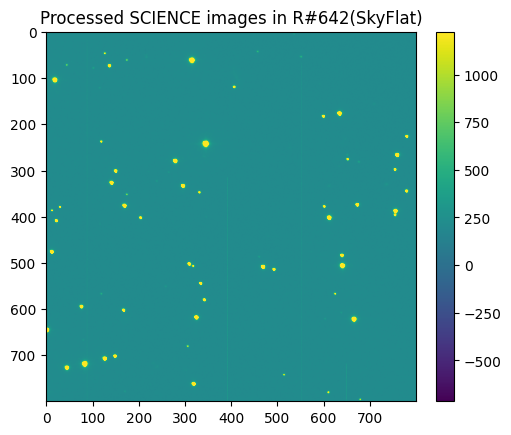

In [71]:
import os
import astropy.io.fits as fits
import dfitspy
import photutils.aperture as aptr
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
##========================================= dirs
dirEx3 = '/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex3/'
dirSTD = '/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex3/STANDARD'
dirErr = '/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex3/PSError'
dirPC = '/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex3/PhotoCalibration'
dirPS = '/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex2/M67/ProcessSCIENCE/'
filters =['V#641','R#642','B#639']
fileNames = {'V#641':'EFOSC.2001-01-03T08:55:18.187.fits',
             'R#642':'EFOSC.2001-01-03T08:56:03.899.fits',
             'B#639':'EFOSC.2001-01-03T08:54:27.270.fits'}
stdName = ['PG-1323-086', 'PG-1323-086 B', 'PG-1323-086 C']
extCoeff = [0.13, 0.09, 0.25]
coos = [np.array([733,451]),np.array([204,158]),np.array([231,589])]
apertureFactor = np.arange(0.5, 4.5, 0.5, dtype ='f')
#==================================================================  
LandoltBands = ['V', 'B-V', 'U-B', 'V-R', 'R-I', 'V-I']
# PG 1323-086		13.481	-0.140	-0.681	-0.048	-0.078	-0.127
# PG 1323-086 B		13.406	0.761	0.265	0.426	0.407	0.833
# PG 1323-086 C		14.003	0.707	0.245	0.395	0.363	0.759
LandoltBand = [[13.481,	-0.140,	-0.681,	-0.048,	-0.078,	-0.127],
                [13.406,	0.761,	0.265,	0.426,	0.407,	0.833],
                [14.003,	0.707,	0.245,	0.395,	0.363,	0.759]]
#combination of 0, B, C with V, R, B
LandoltMag = np.zeros((3,3), dtype = 'f')
for i in range(len(LandoltBand)):
    LandoltMag[i][0] = LandoltBand[i][0]
    LandoltMag[i][1] = LandoltBand[i][0] - LandoltBand[i][3]
    LandoltMag[i][2] = LandoltBand[i][0] + LandoltBand[i][1]
#==================================================================  
'''
@seeFits()
check the header
'''
def seeFits():
    prevDir = os.getcwd()
    os.chdir(dirSTD)
    fitsFiles = [m for m in os.listdir() if m.endswith('.fits')]
    for f in fitsFiles:
        header = fits.getheader(f)
        print(header)
    # stdFiles = dfitspy.dfitsort(fitsFiles)
    # dfitspy.dfitsort_view(stdFiles)
    os.chdir(prevDir)
#==================================================================  
'''
@getExpTime()
@returns exposure time
'''
def getExpTime(filter):
    fileName = fileNames[filter]
    return float(fits.getheader(fileName)['EXPTIME'])
#==================================================================  
'''
@getAirmass()
get airmass values from header of the .fits file of the standard stars in V, R, B filters
'''
def getAirmass(filter):
    prevDir = os.getcwd()
    os.chdir(dirSTD)
    fileName = fileNames[filter]
    am = float(fits.getheader(fileName)['HIERARCH ESO TEL AIRM START'])
    os.chdir(prevDir)
    return am
##========================================= load fits data
def getStdFitsData(fileName):
    fitsStdData = fits.getdata(fileName, header = False, dtype = 'f')
    stdData = fitsStdData[100:900,100:900]
    return stdData
##========================================= load processed science data
def getPSData(filter, type):
    prevDir = os.getcwd()
    os.chdir(dirPS)
    pSData = [ [0]*800 for i in range(800) ]
    os.chdir(dirPS)
    fileName = filter+type+'.processed'
    # return np.loadtxt(fileName,delimiter=',',usecols=[0,799])
    if os.path.exists(fileName):
        with open(fileName, "r") as file:
            ##load data from file
            listOfLines = file.read().splitlines()   #list of strings
            for i in range(len(listOfLines)):
                line = listOfLines[i] #list of string, delimiter = ','
                listOfValues = line.split(',')
                for j in range(len(listOfValues)):
                    value = listOfValues[j]
                    if not value =='':
                        pSData[i][j] = float(value)
    os.chdir(prevDir)
    return pSData
##========================================= load processed science error    
def getPSError(fileName):
    fitsStdData = fits.getdata(fileName, header = False, dtype = 'f')
    stdData = fitsStdData[100:900,100:900]
    return stdData
##=========================================    
def getPSError(filter, type):
    previousDir = os.getcwd()
    pSError = [ [0]*800 for i in range(800) ]
    os.chdir(dirErr)
    fileName = filter+type+'.processed.error'
    if os.path.exists(fileName):
        with open(fileName, "r") as file:
            ##load data from file
            listOfLines = file.read().splitlines()   #list of strings
            for i in range(len(listOfLines)):
                line = listOfLines[i] #list of string, delimiter = ','
                listOfValues = line.split(',')
                for j in range(len(listOfValues)):
                    value = listOfValues[j]
                    if not value =='':
                        pSError[i][j] = float(value)
    os.chdir(previousDir)
    return pSError
#==================================================================
class Statistics:
    #=======================CTOR===================================\
    def __init__(self, coo, stdData, errorData, expTime, airmass, f, extC, landolt):
        self.prevDir = os.getcwd()
        os.chdir(dirPC)
        self.coo = coo
        self.stdData = stdData
        self.errorData = errorData
        self.expTime = expTime
        self.airmass = airmass
        self.extC = extC
        self.landolt = landolt
        self.f = f
        self.__setRadialProfile()
        self.FWHM = self.rp.gaussian_fwhm
        self.__setRadii()
        self.__setApertureCircle()
        self.__setCircularAptrPhot()
        self.__setApertureAnnulus()
        self.__setAnnulusBackground()
        self.__setCcdMag()
        self.__setMagErr()
        
        self._setZP()
        self.__setCountMag()
        self.__setCountMagErr()
    #=======================DTOR===================================\   
    def __del__(self):
        os.chdir(self.prevDir)
    #==========================================================private methods
    def __setRadialProfile(self):
        xycen = centroid_quadratic(self.stdData, xpeak = self.coo[0], ypeak = self.coo[1], fit_boxsize = 11, search_boxsize = 11)
        edge_radii = np.arange(4)
        rp = RadialProfile(self.stdData, xycen, edge_radii, mask=None)
        self.rp = rp
    def __setApertureCircle(self):
        self.aptrC = CircularAperture(self.coo, self.f * self.FWHM )
    def __setApertureAnnulus(self):
        self.aptrA = CircularAnnulus(self.coo, r_in = self.rIn, r_out = self.rOut)
    def __setRadii(self):
        self.rIn = self.FWHM*3
        self.rOut = (1.3) * self.rIn
    def __setCircularAptrPhot(self):
        self.phot = aptr.aperture_photometry(self.stdData, self.aptrC, method ='subpixel', error = self.errorData, subpixels = 5)
    def __setAnnulusBackground(self):
        annulus_masks = self.aptrA.to_mask(method='center')
        annulus_data = annulus_masks.multiply(self.stdData)
        annulus_data_1d = annulus_data[annulus_masks.data > 0]
        _, bkg_median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        self.aBG = bkg_median_sigclip
        self.phot['annulus_median'] = self.aBG
        self.phot['aper_bkg'] = bkg_median_sigclip * self.aptrC.area
        self.corrAptrC = float(self.phot['aperture_sum']) - float(self.phot['aper_bkg'])
        
    def __setCcdMag(self):
        power = (self.phot['aperture_sum']/self.expTime) - (self.aBG/self.expTime)
        self.ccdMag =  float(-2.5*( np.log10(power) ) + 25)
        
    def __setMagErr(self):
        phot = aptr.aperture_photometry(np.square(self.errorData), self.aptrC)
        aptrErr = float(phot['aperture_sum']) + (self.aptrC.area**2 / self.aBG * self.aBG)
        self.magErr = 1.0857 * np.sqrt(aptrErr)/float(phot['aperture_sum'])
        
    def _setZP(self):
        zpCor = self.landolt-(self.ccdMag - self.extC*self.airmass)
        self.zp = 25 + zpCor
        
    def __setCountMag(self):
        power = float(self.phot['aperture_sum']*self.expTime)
        self.countMag = -2.5 * np.log(power) - self.extC*self.airmass
        
    def __setCountMagErr(self):
        self.countMagErr = 1.0857 * float(self.phot['aperture_sum']*self.expTime) - self.extC * self.airmass
    
    #==========================================================public methods
    def getFWHM(self):
        return self.FWHM
    def getBGMedian(self):
        return self.bgMedian
    def getCorrectedAptr(self):
        return self.corrAptrC
    def getCcdMag(self):
        return self.ccdMag
    def getMagErr(self):
        return self.magErr
    def getZP(self):
        return self.zp
    def getCountMag(self):
        return self.countMag
    def getCountMagErr(self):
        return self.countMagErr

PICK = 7.0
os.chdir(dirPC)
# fig, axStd = plt.subplots(1,3,figsize = (15,5))
# fig, axPS = plt.subplots(1,3,figsize = (15,5))
for filter, fileName in fileNames.items():
    stdData = getFitsData(fileName)
    sciData = getPSData(filter, 'SkyFlat')
    stdSci = np.std(sciData)
    print('std : ', stdSci)
    errorData = getPSError(filter, 'SkyFlat')
    expTime = getExpTime(filter)
    airmass = getAirmass(filter)
    iflt = filters.index(filter)
    extC = extCoeff[iflt]
    print('=========================',filter,'=========================')
    # imPS = axPS[iflt].imshow(sciData , vmin = np.mean(sciData) - np.std(sciData), vmax = np.mean(sciData) + np.std(sciData))
    # axPS[iflt].set_title('processed SCIENCE in '+filter+'(SkyFlat)')
    # fig.colorbar(imPS, ax = axPS[iflt],fraction=0.046, pad=0.04)
    # # plt.savefig('Processed_Science.png')
    # imStd = axStd[iflt].imshow(stdData , vmin = np.mean(stdData) - np.std(stdData), vmax = np.mean(stdData) + np.std(stdData))
    # axStd[iflt].set_title('Standard image in '+filter+'(SkyFlat)')
    # fig.colorbar(imStd, ax = axStd[iflt],fraction=0.046, pad=0.04)
    # plt.savefig('Standard_Stars.png')
    
    # plt.colorbar(imPS, ax = axPS[iflt],fraction=0.046, pad=0.04)
    if filter == filters[1]:
        # plt.imshow(stdData , vmin = np.mean(stdData) - np.std(stdData), vmax = np.mean(stdData) + np.std(stdData))
        # plt.title('Standard Stars in '+filter+'(SkyFlat)')
        # plt.colorbar(fraction=0.046, pad=0.04)
        # plt.savefig('Standard_Star'+filter+'.png')
        plt.imshow(sciData , vmin = np.mean(sciData) - np.std(sciData), vmax = np.mean(sciData) + np.std(sciData))
        plt.title('Processed SCIENCE images in '+filter+'(SkyFlat)')
        plt.colorbar(fraction=0.046, pad=0.04)
        # plt.savefig('Processed_Science'+filter+'.png')
    
    # for star in stdName:
    #     print('-----------------',star,'-----------------')
    #     iStd = stdName.index(star)
    #     landMag = LandoltMag[iflt][iStd]
    #     s = Statistics(coos[iStd], stdData, errorData, expTime, airmass, PICK, extC, landMag)
    #     daofind = DAOStarFinder(fwhm = PICK, threshold = 8.*stdSci)
    #     sources = daofind(stdData)
    #     # print(sources)
    #     print('# : ', len(sources))
plt.show()
        
    
